In [263]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt 
from functions import *
import math

Selecting a J-stiffener here. The stiffener is aligned along the length direction of the fuselage. X-direction. or in the dimension of a for the purpose of our analysis.

Amongst global buckling of the fuselage and the localized buckling of skin between two stiffeners, the localized buckling is preferred to occur first because it is easier to redistribute load and avoid total collapse of the structure when failure is localized.

1/lambda = ratio of the total compressive load taken by the skin alone.
Important: Stiffeners are expected to take most of the compressive load and the skin most of the shear load.

In [264]:
#Properties of UD tape
E_x = 142e3 #MPa
E_y = 11.2e3 #MPa
G_xy = 5e3 #MPa
v_xy = 0.3
X_t = 2200 #MPa
X_c = 1800 #MPa
Y_t = 70 #MPa
Y_c = 300 #MPa
S = 100 #MPa
t_ply = 0.135 #mm
D_outer = 6000 #mm
rho = 1610e-9 #kg/mm^3 
knockdown_factor = 0.8 * 0.65 * 0.8 #Environment/damage/Material scatter
M = 15e9 #N-mm
V = 1.5e6 #N

In [265]:
#EI of the stiffeners
def lambda_calc(A,E,ds):
    lambda_ = (A[0][0] + E*A/ds)/A[0][0]
    return lambda_

def thickness_(theta):
    thickness = [t_ply] * len(theta)
    return thickness

def properties_(theta):
    properties = [[E_x, E_y, v_xy, G_xy]] * len(theta)
    return properties

def axial_stiffness(A,lambda_,ds):
    stiffness_EA = A[0][0]*(lambda_-1)*ds
    return stiffness_EA

def bending_stiffness(D,a,b,ds,lambda_):
    #lambda_ = lambda_calc(E,A,ds) #change if required
    AR = a/b
    AR_ = a/ds
    D_11 = D[0][0]
    D_22 = D[1][1]
    D_12 = D[0][1]
    D_66 = D[2][2]
    stiffness_EI = D_11 * ds* (np.sqrt(D_22/D_11)*(2*lambda_ * AR_**2 - np.sqrt(D_22/D_11)*AR**4)+ (2*(D_12+2*D_66))/(D_11)*(lambda_* AR_**2-(AR)**2)-1)
    return stiffness_EI



def buckling_compression_alone(D,a,b,ds,m):
    AR_ = a/ds
    D_11 = D[0][0]
    D_12 = D[0][1]
    D_66 = D[2][2]
    D_22 = D[1][1]
    N_o = np.pi**2/a**2 * (D_11*m**2+2*(D_12+2*D_66)*AR_**2+D_22 * AR_**4/m**2)
    return N_o

def shear_alone(D,a,b):
    D_11 = D[0][0]   #Change equation for a/b > 1 if you have time later on
    D_22 = D[1][1]
    D_12 = D[0][1]
    D_66 = D[2][2]
    D1 = D_11 + D_22 * (a/b)**4 + 2*(D_12 + 2* D_66) *(a/b)**2
    D2 = D_11 + 81*D_22 * (a/b)**4 + 18*(D_12 + 2* D_66) *(a/b)**2
    D3 = 81*D_11 + D_22 * (a/b)**4 + 18*(D_12 + 2* D_66) *(a/b)**2
    N_o = (np.pi**4*b/a**3)*1 /np.sqrt((14.28/D1**2)+(40.96/(D1*D2))+(40.96/(D1*D3)))
    return N_o

def buckled_not(lambda_,D,a,b,ds,m,N_x,N_xy):
    N_x_skin = N_x/lambda_ 
    N_x_critical = buckling_compression_alone(D,a,b,ds,m)/lambda_
    N_xy_critical = shear_alone(D,a,b)
    buckling_factor = abs(N_x_skin)/abs(N_x_critical) + (N_xy/N_xy_critical)**2
    # if buckling_factor <1:
    #     print("Safe, No buckling")
    # else:
    #     print("Buckled")
    R = sp.symbols('R', real = True)
    eqn = abs(N_x_skin)*R/abs(N_x_critical) + (N_xy/N_xy_critical)**2 *R**2- 1
    
    R_array = sp.solve(eqn, R)
    if len(R_array) == 2:
        if R_array[0] >=1:
            reserve_factor = R_array[0]
        elif R_array[1] >=1:
            reserve_factor = R_array[1]
        else:
            reserve_factor = min(R_array)
    else:
        reserve_factor = R_array[0]
    margin_of_safety = reserve_factor - 1
    return buckling_factor, reserve_factor, margin_of_safety 


def EA_EI_equivalent_J(theta_L2, theta_L3, length_L1, length_L2, length_L3):
    # thickness_t1 = 0.135 * len(theta_L1)
    # # thickness_t1_layup = thickness_(theta_L1)
    # properties_t1 = properties_(theta_L1)
    thickness_t2 = 0.135 * len(theta_L2)
    thickness_t2_layup = thickness_(theta_L2)
    properties_t2 = properties_(theta_L2)
    thickness_t3 = 0.135 * len(theta_L3)
    thickness_t3_layup = thickness_(theta_L3)
    properties_t3 = properties_(theta_L3)
    #A_1,B_1,D_1,z_1 = ABD_matrix_differentMaterial(thickness_t1_layup, theta_L1, properties_t1)
    A_2,B_2,D_2,z_2 = ABD_matrix_differentMaterial(thickness_t2_layup, theta_L2, properties_t2)
    A_3,B_3,D_3,z_3 = ABD_matrix_differentMaterial(thickness_t3_layup, theta_L3, properties_t3)
    #Ex_1,Ey_1,vxy_1,vyx_1,Gxy_1 = laminate_properties(thickness_t1, A_1)
    Ex_2,Ey_2,vxy_2,vyx_2,Gxy_2 = laminate_properties(thickness_t2, A_2)
    Ex_3,Ey_3,vxy_3,vyx_3,Gxy_3 = laminate_properties(thickness_t3, A_3)
    #Exb_1,Eyb_1,vxyb_1,vyxb_1,Gxyb_1 = laminate_properties_bending(thickness_t1, D_1)
    Exb_2,Eyb_2,vxyb_2,vyxb_2,Gxyb_2 = laminate_properties_bending(thickness_t2, D_2)
    Exb_3,Eyb_3,vxyb_3,vyxb_3,Gxyb_3 = laminate_properties_bending(thickness_t3, D_3)
    full_thickness = length_L2 + thickness_t3
    #EA_1 = Ex_1 * length_L1 * thickness_t1
    EA_2 = Ex_2 * length_L2 * thickness_t2 
    EA_3 = Ex_3 * length_L3 * thickness_t3 
    EA_eq =  Ex_2 * length_L2 * thickness_t2 + Ex_3 * length_L3 * thickness_t3
    if thickness_t2+thickness_t3>=10:
        y_ =  (Ex_2 * length_L2 * thickness_t2 * (thickness_t3+length_L2/2) + Ex_3 * length_L3 * thickness_t3 * (thickness_t3/2))/( Ex_2 * length_L2 * thickness_t2 + Ex_3 * length_L3 * thickness_t3)
        EI_eq =  Ex_2 *(thickness_t2*length_L2**3/12 + length_L2 * thickness_t2 * ( length_L2/2 - y_)**2) + Ex_3 * (length_L3 * thickness_t3 **3/12 + length_L3 * thickness_t3 * (y_ - thickness_t3/2)**2)
    else:
        y_ =  ( Exb_2 * length_L2 * thickness_t2 * (thickness_t3+length_L2/2) + Exb_3 * length_L3 * thickness_t3 * (thickness_t3/2))/( Exb_2 * length_L2 * thickness_t2 + Exb_3 * length_L3 * thickness_t3)
        EI_eq =  Exb_2 *(thickness_t2*length_L2**3/12 + length_L2 * thickness_t2 * ( length_L2/2 - y_)**2) + Exb_3 * (length_L3 * thickness_t3 **3/12 + length_L3 * thickness_t3 * (y_ - thickness_t3/2)**2)
    return EA_eq, EI_eq, EA_2, EA_3


def layup_stiffener(EA,EI,length_L1,length_L2,length_L3,lambda_,b,a,N_x):
    theta_L2_ = [+45,-45,0,0,45,-45,0,0,0,90,90,0,0,0,-45,45,0,0,-45,45] #* 3 #Layers for Member 2 (the web portion)#Layers for Member 1 and 3 (the flange portion)
    # theta_L1_ = [+45,-45,0,0,0,0,90,0,0,0,-45,45] #* 3 #Layers for Member 1 and 3 (the flange portion)
    theta_L3_ = [+45,-45,0,0,0,0,90,0,0,0,-45,45]
    EA_eq, EI_eq,EA_2,EA_3 =  EA_EI_equivalent_J(theta_L2_, theta_L3_, length_L1, length_L2, length_L3)
    i = 2
    while (EA_eq < EA and EI_eq < EI):
        #theta_L1 = theta_L1_ * i
        theta_L2 = theta_L2_ * i
        theta_L3 = theta_L3_ * i
        EA_eq, EI_eq,EA_2,EA_3 =  EA_EI_equivalent_J(theta_L2, theta_L3, length_L1, length_L2, length_L3)
        i += 1
    EA,EI,EA_2,EA_3 = EA_EI_equivalent_J(theta_L2_,theta_L3_,length_L1,length_L2,length_L3)
    F_critical = Euler_Beam_buckling(a, EI)
    area_combined = [length_L2*len(theta_L2_)*0.135,length_L3*len(theta_L3_)*0.135]
    F_stiffener, F_skin,margin_of_safety_column_buckling = Force_on_stiffener(lambda_,b,N_x,F_critical)
    
    stress_in_member, cripling_load_member = Cripling_table([EA_2,EA_3], [theta_L2_,theta_L3_],area_combined,b,N_x,X_c)
    criple = [0,0]
    if abs(stress_in_member[0]) > abs(cripling_load_member[0]) :
        criple[0] = 1
    elif abs(stress_in_member[1]) > abs(cripling_load_member[1]):
        criple[1] = 1
    theta_L2 = []
    theta_L3 = [] 
    while  margin_of_safety_column_buckling <= 1 or criple[0] ==1 or criple[1] == 1:
        if margin_of_safety_column_buckling <=1:
            for i in range(len(theta_L2_)):
                if i < len(theta_L2_)/2:
                    theta_L2.append(theta_L2_[i])
                elif i == math.ceil(len(theta_L2_)/2):
                    theta_L2.append(0)
                    theta_L2.append(0)
                else:
                    theta_L2.append(theta_L2_[i])
            for i in range(len(theta_L3_)):
                if i < len(theta_L3_)/2:
                    theta_L3.append(theta_L3_[i])
                elif i == math.ceil(len(theta_L3_)/2):
                    theta_L3.append(0)
                    theta_L3.append(0)
                else:
                    theta_L3.append(theta_L3_[i]) 
            theta_L2_ = theta_L2
            theta_L2 = []
            theta_L3_ = theta_L3
            theta_L3 = []    
        if criple[0] == 1:
            for i in range(len(theta_L2_)):
                if i < len(theta_L2_)/2:
                    theta_L2.append(theta_L2_[i])
                elif i == math.ceil(len(theta_L2_)/2):
                    theta_L2.append(0)
                    theta_L2.append(0)
                else:
                    theta_L2.append(theta_L2_[i])
            theta_L2_ = theta_L2
            theta_L2 = []      
        
        if criple[1] == 1:
            for i in range(len(theta_L3_)):
                if i < len(theta_L3_)/2:
                    theta_L3.append(theta_L3_[i])
                elif i == math.ceil(len(theta_L3_)/2):
                    theta_L3.append(0)
                    theta_L3.append(0)
                else:
                    theta_L3.append(theta_L3_[i])
            theta_L3_ = theta_L3
            theta_L3 = []   
        
        EA,EI,EA_2,EA_3 = EA_EI_equivalent_J(theta_L2_,theta_L3_,length_L1,length_L2,length_L3)
        F_critical = Euler_Beam_buckling(a, EI)
        area_combined = [length_L2*len(theta_L2_)*0.135,length_L3*len(theta_L3_)*0.135]
        F_stiffener, F_skin,margin_of_safety_column_buckling = Force_on_stiffener(lambda_,b,N_x,F_critical)
        stress_in_member, cripling_load_member = Cripling_table([EA_2,EA_3], [theta_L2_,theta_L3_],area_combined,b,N_x,X_c)
        
        
        if abs(stress_in_member[0]) > abs(cripling_load_member[0]):
            criple[0] = 1
        else:
            criple[0] = 0
        if abs(stress_in_member[0]) > abs(cripling_load_member[0]):
            criple[1] = 1
        else:
            criple[1] = 0
    EA,EI,EA_2,EA_3 = EA_EI_equivalent_J(theta_L2_,theta_L3_,length_L1,length_L2,length_L3)
    print(EA)
    print(EI)
    return theta_L2_, theta_L3_

def layup_skin(E1,E2,v12,G12, lambda_,a,b,ds,N_x,N_xy,y):
    theta_ = [45,-45,0,45,-45,45,-45,90,-45,45,-45,45,0,-45,45]
    properties = [[E1,E2,v12,G12]] * len(theta_)
    thickness = [0.135] * len(theta_)
    A,B,D,z = ABD_matrix_differentMaterial(thickness, theta_, properties) 
    buckling_factor, reserve_factor, margin_of_safety  = buckled_not(lambda_,D,a,b,ds,3,N_x,N_xy)
    theta = []
    while buckling_factor >= 1 or reserve_factor <=2:
        for j in range(len(theta_)):
            if j < len(theta_)/2:
                theta.append(theta_[j])
            elif j == math.ceil(len(theta_)/2):
                theta.append(0)
                theta.append(0)
            else:
                theta.append(theta_[j])
        properties = [[E1,E2,v12,G12]] * len(theta)
        thickness = [0.135] * len(theta)
        A,B,D,z = ABD_matrix_differentMaterial(thickness, theta, properties)
        buckling_factor, reserve_factor, margin_of_safety  = buckled_not(lambda_,D,a,b,ds,2,N_x,N_xy)
        # print("The buckling factor is " + str(buckling_factor))
        # print("The reserve factor is " + str(reserve_factor))     
        theta_ = theta
        theta = []
    return theta_, properties, thickness, buckling_factor, reserve_factor, margin_of_safety

def layup_skin_without_buckling(E1,E2,v12,G12,Force_per_length,y):
    theta_ = [45,-45,0,45,-45,45,-45,90,-45,45,-45,45,0,-45,45]
    properties = [[E1,E2,v12,G12]] * len(theta_)
    thickness = [0.135] * len(theta_)
    A,B,D,z = ABD_matrix_differentMaterial(thickness, theta_, properties)
    stress_laminas = stress_per_lamina_differentMaterials(Force_per_length, theta_, A,B,D, properties,z)
    failed = Puck(stress_laminas,X_t,X_c,Y_t,Y_c,S)
    theta = theta_
    while failed == 1:
        if y<=1 and y>=-1:
            for j in range(len(theta_)):
                if j < len(theta_)/2:
                    theta.append(theta_[j])
                elif j == math.ceil(len(theta_)/2):
                    theta.append(45)
                    theta.append(45)
                else:
                    theta.append(theta_[j])
        else:
            for j in range(len(theta_)):
                if j < len(theta_)/2:
                    theta.append(theta_[j])
                elif j == math.ceil(len(theta_)/2):
                    theta.append(45)
                    theta.append(45)
                else:
                    theta.append(theta_[j])
        properties = [[E1,E2,v12,G12]] * len(theta)
        thickness = [0.135] * len(theta)
        A,B,D,z = ABD_matrix_differentMaterial(thickness, theta, properties)
        failed = Puck(stress_laminas,X_t,X_c,Y_t,Y_c,S)
        theta_ = theta
        theta = []
    return theta

def Euler_Beam_buckling(a,EI):
    F_critical = np.pi **2/a**2 *(EI)
    return F_critical

def Cripling_load(sigma_c_u, b, t,i):
    # if i == 1:
    #sigma_crip = sigma_c_u * 2.151/(b/t)**0.717
    # elif i == 0:
    sigma_crip = sigma_c_u * 14.92/(b/t)**1.124
    return sigma_crip

def Force_on_stiffener(lambda_, b, N_x, F_critical):
    F_Tot = b * abs(N_x)
    F_skin = 1/lambda_ * F_Tot
    F_stiffener = (lambda_-1)/lambda_ * F_Tot
    margin_of_safety_column_buckling = F_critical/F_stiffener - 1 #Cocuring
    return F_stiffener, F_skin,margin_of_safety_column_buckling

def Cripling_table(EA_combined, theta_combined,area_combined,b,N_x,sigma_c_u):
    stress_in_member = []
    cripling_load_member = []
    F_Tot = b * N_x
    for i in range(2):
        force_in_member = EA_combined[i]/(sum(EA_combined))*F_Tot
        stress_in_member.append(force_in_member/area_combined[i])
        cripling_load_member.append(Cripling_load(sigma_c_u, b, len(theta_combined[i])*0.135,i))
    return stress_in_member, cripling_load_member

In [266]:
# a = 1.5 b = 1m for now. Recalculate once we use actual loads and layups. Also other parameters are defined here. 
# Make sure to change these or optimize before final design
# a = 1000 #mm
# b = 1500 #mm
# ns = 10 #number of stiffners
# ds = b/(ns-1) #spacing between the stiffeners. Think of calculating number of stiffeners based on the spacing later.
# # ds = 125
# # ns = b/ds + 1
# lambda_ = 8
theta = [45,-45,0,45,-45,45,-45,90,-45,45,-45,45,0,-45,45]
thickness = thickness_(theta)
# #compressive load total
# N_x = -420
# N_xy = 160
# F_c_total = b*N_x
# F_skin = 1/lambda_ * F_c_total
# F_stiffener = (lambda_-1)/lambda_ * F_c_total

# N_x_skin = F_skin/b

# # theta, properties, thickness, buckling_factor, reserve_factor, margin_of_safety = layup_skin(E_x,E_y, v_xy,G_xy, lambda_, a, b, ds, N_x, N_xy)
# # A,B,D,z = ABD_matrix_differentMaterial(thickness, theta, properties)
# # thickness_layup =sum(thickness)


# # EA = axial_stiffness(A,lambda_, ds) #Units: N
# # EI = bending_stiffness(A,a,b,ds,lambda_) #Units: N mm^2

# # theta_L1, theta_L2, theta_L3 = layup_stiffener(EA,EI,50,100,100, lambda_,b,a,N_x)

# # print(len(theta_L1), len(theta_L2))


#Meanwhile N_xy_skin would just be N_xy. This is because the stiffeners would not contribute anything to carry the shear load.
#Buckling:

#N_x_critical and N_xy_critical are the critical buckling loads for pure compression and shear respectively.



In [267]:
#Going for conservative design as we are not including the stiffener panels in the moment of inertia
def force(thickness, y, D_outer, M, V):
    total_thickness = np.sum(thickness)
    D_inner = D_outer - 2 * total_thickness
    I = np.pi*(D_outer**4 - D_inner**4)/64
    sigma = M*y/I
    Nx = sigma * total_thickness
    R_outer = D_outer/2
    R_inner = D_inner/2
    if abs(y)>abs(R_inner):
        tau = (4/(3*np.pi)) * V * (R_outer**2 - y**2)/(R_outer**4 - R_inner**4)
        Ns = tau * total_thickness
    else:
        tau = (4/(3*np.pi)) * V * (R_outer**2 - 2*y**2+ np.sqrt(R_inner**2-y**2)*np.sqrt(R_outer**2-y**2) + R_inner**2)/(R_outer**4 - R_inner**4)
        Ns = tau * total_thickness
    Force_per_length = np.array([[Nx],[0],[Ns],[0],[0],[0]])
    return Force_per_length


In [268]:
y = np.arange(-3000,3001,1000)
mos_skin = []
bf_skin = []
rf_skin = []
lambda_ = 8
theta_skin = []
theta_stiffener_1 = []
theta_stiffener_2 = []
theta_stiffener_3 = []
number_stiffener = []
length_L1 = [27,32,37,42,37,32,27]
length_L2 = [54,64,74,84,74,64,54]
length_L3 = [54,64,74,84,74,64,54]
theta1 = np.array([45, -45, 45, -45, 0, 90, 0, -45, 45, -45, 45, 0, 90])
theta1 = np.concatenate((theta1, theta1[::-1]))
theta1 = np.concatenate((theta1, theta1))

theta2 = np.array([45, -45, 45, -45, 45, 0, 90, 0, -45, 45, -45, 45, 0, 90])
theta2 = np.concatenate((theta2, theta2[::-1]))
theta2 = np.concatenate((theta2, theta2))

theta3 = np.array([45, -45, 45, -45, 45, 0, 90, 0 -45, 45, -45, 45, 0, 90])
theta3 = np.concatenate((theta3, theta3[::-1]))
theta3 = np.concatenate((theta3, theta3))

theta4 = np.array([45, -45, 45, -45, 45, 0, 90, 0, 9 -45, 45, -45, 45, 0, 90, 0])
theta4 = np.concatenate((theta4, theta4[::-1]))
theta4 = np.concatenate((theta4, theta4))

theta5 = np.array([45, -45, 45, -45, 45, 0, 90, 0, -45, 45, -45, 45, 0, 90, 0, 90])
theta5 = np.concatenate((theta5, theta5[::-1]))
theta5 = np.concatenate((theta5, theta5))

theta6 = np.array([45, -45, 45, -45, 45, 0, 90, 0, -45, 45, -45, 45, 0, 0, 90, 0, 90])
theta6 = np.concatenate((theta6, theta6[::-1]))
theta6 = np.concatenate((theta6, theta6))
count = 0
for i in y:
    Force_per_length = force(thickness, i,D_outer, M, V)
    if True:
        a = 600
        if i == -3000:
            b = D_outer/2 * np.pi/180 * 180/(len(y)-1)
            b =600
            ds = 200
            ns = math.ceil(b/ds + 1)
        else:
            b = D_outer/2 * np.pi/180 * 180/(len(y)-1) -125
            b = 600
            ds = 125
            ns = math.ceil(b/ds + 1)
        print("The number of stiffeners are " + str(ns))
        N_x = Force_per_length[0][0]
        N_xy = Force_per_length[2][0]
        theta, properties, thickness, buckling_factor, reserve_factor, margin_of_safety = layup_skin(E_x,E_y, v_xy,G_xy, lambda_, a, b, ds, N_x, N_xy,i)
        properties = properties_(theta)
        thickness = thickness_(theta)
        A,B,D,z = ABD_matrix_differentMaterial(thickness, theta, properties)
        #Check for Puck criteria stresses in the skin
        stress_laminas = stress_per_lamina_differentMaterials(Force_per_length, theta, A,B,D, properties,z)
        failed = Puck(stress_laminas, X_t,X_c,Y_t,Y_c,S)
        EA = axial_stiffness(A,lambda_, ds) #Units: N
        EI = bending_stiffness(A,a,b,ds,lambda_) #Units: N mm^2
        print("The final skin layers for y= " +str(i) +  " is " + str(len(theta)))
        if failed == 0:
            print("Puck criteria also satisfied")
        else:
            print("First ply failure happening within this")
        theta_L2,theta_L3 = layup_stiffener(EA,EI,length_L1[count],length_L2[count],length_L3[count],lambda_,b,a,N_x)
        theta_skin.append(theta)
        #theta_stiffener_1.append(theta_L1)
        theta_stiffener_2.append(theta_L2)
        theta_stiffener_3.append(theta_L3)
        number_stiffener.append(ns)
        mos_skin.append(margin_of_safety)
        rf_skin.append(reserve_factor)
        bf_skin.append(buckling_factor)
    else:
        a = 600
        if i == -3000:
            b = D_outer/2 * np.pi/180 * 180/(len(y)-1)
            b = 600
            ds = 200
            ns = math.ceil(b/ds + 1)
        else:
            b = D_outer/2 * np.pi/180 * 180/(len(y)-1) -125
            b = 600
            ds = 125
            ns = math.ceil(b/ds + 1)
        N_x = Force_per_length[0][0]
        N_xy = Force_per_length[2][0]
        theta = layup_skin_without_buckling(E_x,E_y,v_xy,G_xy,Force_per_length,i)
        thickness = thickness_(theta)
        properties = properties_(theta)
        A,B,D,z = ABD_matrix_differentMaterial(thickness, theta, properties)
        theta_L2_ = [+45,-45,0,0,45,-45,0,0,0,90,90,0,0,0,-45,45,0,0,-45,45] #* 3 #Layers for Member 2 (the web portion)#Layers for Member 1 and 3 (the flange portion)
        theta_L1_ = [+45,-45,0,0,0,0,90,0,0,0,-45,45] #* 3 #Layers for Member 1 and 3 (the flange portion)
        theta_L3_ = [+45,-45,0,0,0,0,90,0,0,0,-45,45]
        theta_skin.append(theta)
        #theta_stiffener_1.append(theta_L1)
        theta_stiffener_2.append(theta_L2)
        theta_stiffener_3.append(theta_L3)
        number_stiffener.append(ns)
    count+=1
    

print(number_stiffener)  
  
    # else:
        
        

The number of stiffeners are 6
The final skin layers for y= -3000 is 28
Puck criteria also satisfied
143250630.6483
39712627899.34919
The number of stiffeners are 6
The final skin layers for y= -2000 is 40
Puck criteria also satisfied
125568837.0144
49824167901.45706
The number of stiffeners are 6
The final skin layers for y= -1000 is 46
Puck criteria also satisfied
91198928.1816
50398624075.174706
The number of stiffeners are 6
The final skin layers for y= 0 is 47
Puck criteria also satisfied
31766406.7896
16811936423.00239
The number of stiffeners are 6


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_31864\4006087291.py:277: RuntimeWarning: divide by zero encountered in scalar divide
  margin_of_safety_column_buckling = F_critical/F_stiffener - 1 #Cocuring


The final skin layers for y= 1000 is 46
Puck criteria also satisfied
91198928.1816
50398624075.174706
The number of stiffeners are 6
The final skin layers for y= 2000 is 40
Puck criteria also satisfied
125568837.0144
49824167901.45706
The number of stiffeners are 6
The final skin layers for y= 3000 is 28
Puck criteria also satisfied
143250630.6483
39712627899.34919
[6, 6, 6, 6, 6, 6, 6]


In [269]:
#Mass calculation
mass = 0
for i in theta_skin:
    thickness = thickness_(i)
    t = sum(thickness)
    mass += rho * np.pi/4 * (D_outer**2 - (D_outer-2*t)**2) /(len(y)-1)

print(mass*1000)
for i in range(len(y)):
    mass += (len(theta_stiffener_2[i])*0.135*length_L2[i]+len(theta_stiffener_3[i])*0.135*length_L3[i])*rho*number_stiffener[i]

print(mass*1000)

187.60470968264522
245.4337200826452


[79, 61, 42, 20, 42, 61, 79]
[70, 52, 33, 12, 33, 52, 70]


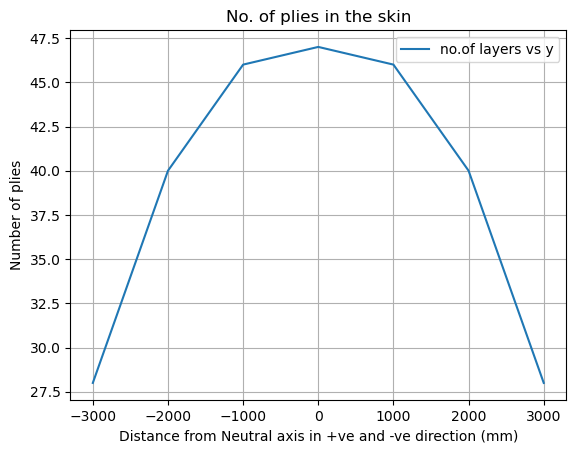

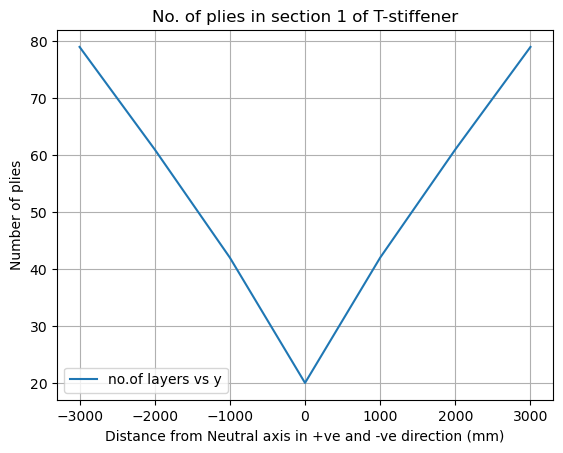

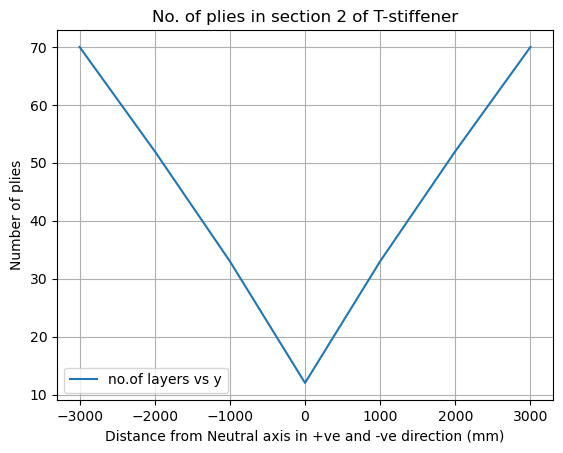

In [270]:
#Plots required
no_layers_skin = []
no_layers_stiffener_1 = []
no_layers_stiffener_2 = []
no_layers_stiffener_3 = []

for i in  theta_skin:
    no_layers_skin.append(len(i))


# for i in theta_stiffener_1:
#     no_layers_stiffener_1.append(len(i))

for i in theta_stiffener_2:
    no_layers_stiffener_2.append(len(i))

for i in theta_stiffener_3:
    no_layers_stiffener_3.append(len(i))

print(no_layers_stiffener_2)
print(no_layers_stiffener_3)

plt.figure(1)
plt.plot(y,no_layers_skin,label ='no.of layers vs y')
plt.xlabel("Distance from Neutral axis in +ve and -ve direction (mm)")
plt.ylabel("Number of plies")
plt.title("No. of plies in the skin")
plt.grid(True)
plt.legend()
plt.show()

# plt.figure(2)
# plt.plot(y,no_layers_stiffener_1,label ='no.of layers vs y')
# plt.xlabel("Distance from Neutral axis in +ve and -ve direction (mm)")
# plt.ylabel("Number of plies")
# plt.title("No. of plies in section 1 of J-stiffener")
# plt.grid(True)
# plt.legend()
# plt.show()

plt.figure(3)
plt.plot(y,no_layers_stiffener_2,label ='no.of layers vs y')
plt.xlabel("Distance from Neutral axis in +ve and -ve direction (mm)")
plt.ylabel("Number of plies")
plt.title("No. of plies in section 1 of T-stiffener")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(4)
plt.plot(y,no_layers_stiffener_3,label ='no.of layers vs y')
plt.xlabel("Distance from Neutral axis in +ve and -ve direction (mm)")
plt.ylabel("Number of plies")
plt.title("No. of plies in section 2 of T-stiffener")
plt.grid(True)
plt.legend()
plt.show()